In [1]:
!pip uninstall torch -y

Found existing installation: torch 2.0.0+cpu
Uninstalling torch-2.0.0+cpu:
  Successfully uninstalled torch-2.0.0+cpu


In [ ]:
!pip install torch==1.13.1

In [3]:
!pip uninstall polars -y

Found existing installation: polars 0.19.19
Uninstalling polars-0.19.19:
  Successfully uninstalled polars-0.19.19


In [4]:
!pip install polars==0.19.2

  Obtaining dependency information for polars==0.19.2 from https://files.pythonhosted.org/packages/c4/f8/0e994906e613f71461a9e85f77c20417dd14dae9e8fed677385627edae5f/polars-0.19.2-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 41.6 MB/s eta 0:00:00:00:010:01


In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import datetime 
from tqdm import tqdm
import torch

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from metric import score # Import event detection ap score function

# These are variables to be used by the score function
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

## Importing data

In [6]:
dt_transforms = [
    pl.col('timestamp').str.to_datetime(), 
    (pl.col('timestamp').str.to_datetime().dt.year()-2000).cast(pl.UInt8).alias('year'), 
    pl.col('timestamp').str.to_datetime().dt.month().cast(pl.UInt8).alias('month'),
    pl.col('timestamp').str.to_datetime().dt.day().cast(pl.UInt8).alias('day'), 
    pl.col('timestamp').str.to_datetime().dt.hour().cast(pl.UInt8).alias('hour')
]

data_transforms = [
    pl.col('anglez').cast(pl.Int16),
    (pl.col('enmo')*1000).cast(pl.UInt16),
]

# Insert the file path to your data here if running locally
train_series = pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

train_events = pl.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv').with_columns(
    dt_transforms
    ).drop_nulls()

test_series = pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

# Removing null events and nights with mismatched counts from series_events
mismatches = train_events.drop_nulls().group_by(['series_id', 'night']).agg([
    ((pl.col('event') == 'onset').sum() == (pl.col('event') == 'wakeup').sum()).alias('balanced')
    ]).sort(by=['series_id', 'night']).filter(~pl.col('balanced'))

for mm in mismatches.to_numpy(): 
    train_events = train_events.filter(~((pl.col('series_id') == mm[0]) & (pl.col('night') == mm[1])))

# Getting series ids as a list for convenience
series_ids = train_events['series_id'].unique(maintain_order=True).to_list()

# Updating train_series to only keep these series ids
train_series = train_series.filter(pl.col('series_id').is_in(series_ids))

## Feature engineering

In [7]:
features, feature_cols = [pl.col('hour')], ['hour']

for mins in [5, 30, 60*2, 60*8] :
    
    for var in ['enmo', 'anglez'] :
        
        features += [
            pl.col(var).rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_mean'),
            pl.col(var).rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_max'),
            pl.col(var).rolling_std(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'{var}_{mins}m_std')
        ]

        feature_cols += [ 
            f'{var}_{mins}m_mean', f'{var}_{mins}m_max', f'{var}_{mins}m_std'
        ]

        # Getting first variations
        features += [
            (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
            (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max'),
            (pl.col(var).diff().abs().rolling_std(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_std')
        ]

        feature_cols += [ 
            f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max', f'{var}_1v_{mins}m_std'
        ]

id_cols = ['series_id', 'step', 'timestamp']

train_series = train_series.with_columns(
    features
).select(id_cols + feature_cols)

test_series = test_series.with_columns(
    features
).select(id_cols + feature_cols)

In [8]:
def make_train_dataset(train_data, train_events, drop_nulls=False) :
    
    series_ids = train_data['series_id'].unique(maintain_order=True).to_list()
    X, y = pl.DataFrame(), pl.DataFrame()
    for idx in tqdm(series_ids) : 
        
        # Normalizing sample features
        sample = train_data.filter(pl.col('series_id')==idx).with_columns(
            [(pl.col(col) / pl.col(col).std()).cast(pl.Float32) for col in feature_cols if col != 'hour']
        )
        
        events = train_events.filter(pl.col('series_id')==idx)
        
        if drop_nulls : 
            # Removing datapoints on dates where no data was recorded
            sample = sample.filter(
                pl.col('timestamp').dt.date().is_in(events['timestamp'].dt.date())
            )
        
        X = X.vstack(sample[id_cols + feature_cols])

        onsets = events.filter((pl.col('event') == 'onset') & (pl.col('step') != None))['step'].to_list()
        wakeups = events.filter((pl.col('event') == 'wakeup') & (pl.col('step') != None))['step'].to_list()

        # NOTE: This will break if there are event series without any recorded onsets or wakeups
        y = y.vstack(sample.with_columns(
            sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
            ).select('asleep')
            )
    
    y = y.to_numpy().ravel()
    
    return X, y

## Training Models

In [9]:
# Collecting datapoints at every 10 minutes
train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).take_every(12 * 10).collect()


# Free up memory
del train_series

In [ ]:
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(series_ids, train_size=0.7, random_state=42)

X, y = make_train_dataset(train_data, train_events)
X = X.to_pandas()

X['labels'] = y

X_train_full = X[X['series_id'].isin(train_ids)]
X_val_full = X[X['series_id'].isin(val_ids)]

y_train = X_train_full['labels']
y_val = X_val_full['labels']


X_train = X_train_full.drop(columns=['labels'], axis=0)
X_val = X_val_full.drop(columns=['labels'], axis=0)


print(f"Training set - X: {X_train.shape}, y: {y_train.shape}")
print(f"Validation set - X: {X_val.shape}, y: {y_val.shape}")

# Delete the orignial dataset after split to preventet OOM errors
del train_data
del X
del y

In [13]:
# Drop the ID columns
X_train = X_train.drop(columns=id_cols)
X_val = X_val.drop(columns=id_cols)


In [14]:
counts = np.bincount(y_train.astype(int))

true_count = counts[1] if len(counts) > 1 else 0  # Count of True values (index 1)
false_count = counts[0] if len(counts) > 0 else 0  # Count of False values (index 0)

print(f"True count: {true_count}, False count: {false_count}")

True count: 178451, False count: 545876


In [15]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader


 
def create_dataset(data, labels, sequence_length):
    '''This function takes the raw data and splits it into sequences of size 'sequence_length',
        creates a tesor of shape [num_samples, sequence_lenght, num_features], splits and aligns the corresponding labels
        and finally returns the data as a TensorDataset
    '''
    num_features = data.shape[1]
    num_samples = len(data) // sequence_length

    sequences = np.array(data[:num_samples * sequence_length])
    sequences = sequences.reshape(num_samples, sequence_length, num_features)

    label_sequences = labels[:num_samples * sequence_length]
    label_sequences = label_sequences.reshape(num_samples, sequence_length)

    sequences_tensor = torch.Tensor(sequences)
#     sequences_tensor = torch.Tensor(sequences.transpose(0, 2, 1)) # Comment out for lstm
    labels_tensor = torch.Tensor(label_sequences)
    
    return TensorDataset(sequences_tensor, labels_tensor)

sequence_length = 12

train_dataset = create_dataset(X_train, y_train.values, sequence_length)
val_dataset = create_dataset(X_val, y_val.values, sequence_length)

# Create DataLoader for training and validating
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [16]:
import torch
import torch.nn as nn

#Also expreimented with a 1-D CNN,

class SleepCNN(nn.Module):
    def __init__(self, input_size, sequence_length):
        super(ComplexSleepCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)

        self._to_linear = None
        self._forward_conv(torch.randn(1, input_size, sequence_length))

        self.fc = nn.Linear(self._to_linear, sequence_length)  

    def _forward_conv(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(-1, self._to_linear)
        x = torch.sigmoid(self.fc(x)) 
        return x

class TimeStepBinaryClassifierLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TimeStepBinaryClassifierLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))

        # Apply fully connected layer for binary classification
        out = self.fc(out)  # Output shape: (batch_size, seq_length, 1)
        
        return out.squeeze(-1)

In [17]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score

input_size = 49 
hidden_size = 32
num_classes = 1  
num_layers = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TimeStepBinaryClassifierLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
model.to(device)


num_epochs = 30
learning_rate = 0.0001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

best_val_loss = float('inf')
early_stopping_counter = 0
early_stopping_patience = 5  # Stop if validation loss does not improve for this many epochs

train_losses = []
val_losses = []
val_f1_macros = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_true = []
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_outputs = torch.sigmoid(val_outputs)
            val_loss += criterion(val_outputs, val_labels.float()).item()
            
            val_predicted_labels = (val_outputs > 0.5).float()
            val_preds.extend(val_predicted_labels.cpu().detach().numpy().reshape(-1))
            val_true.extend(val_labels.cpu().numpy().reshape(-1))
            
    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)
    val_loss /= len(val_loader)
    val_f1_macro = f1_score(val_true, val_preds, average='macro')
    
    # Scheduler step based on validation loss
    scheduler.step(val_loss)
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the best model if needed
        torch.save(model, 'best_model_lstm.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered!")
            break
  

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1 Macro: {val_f1_macro:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_f1_macros.append(val_f1_macro)


Epoch [1/30] - Train Loss: 0.2887, Val Loss: 0.2144, Val F1 Macro: 0.8882, Val Accuracy: 0.9196
Epoch [2/30] - Train Loss: 0.1544, Val Loss: 0.1906, Val F1 Macro: 0.9002, Val Accuracy: 0.9283
Epoch [3/30] - Train Loss: 0.1353, Val Loss: 0.1838, Val F1 Macro: 0.9038, Val Accuracy: 0.9308
Epoch [4/30] - Train Loss: 0.1263, Val Loss: 0.1755, Val F1 Macro: 0.9061, Val Accuracy: 0.9330
Epoch [5/30] - Train Loss: 0.1203, Val Loss: 0.1743, Val F1 Macro: 0.9107, Val Accuracy: 0.9357
Epoch [6/30] - Train Loss: 0.1161, Val Loss: 0.1727, Val F1 Macro: 0.9138, Val Accuracy: 0.9375
Epoch [7/30] - Train Loss: 0.1130, Val Loss: 0.1670, Val F1 Macro: 0.9145, Val Accuracy: 0.9383
Epoch [8/30] - Train Loss: 0.1101, Val Loss: 0.1662, Val F1 Macro: 0.9166, Val Accuracy: 0.9398
Epoch [9/30] - Train Loss: 0.1079, Val Loss: 0.1643, Val F1 Macro: 0.9162, Val Accuracy: 0.9399
Epoch [10/30] - Train Loss: 0.1060, Val Loss: 0.1684, Val F1 Macro: 0.9186, Val Accuracy: 0.9407
Epoch [11/30] - Train Loss: 0.1046, Val

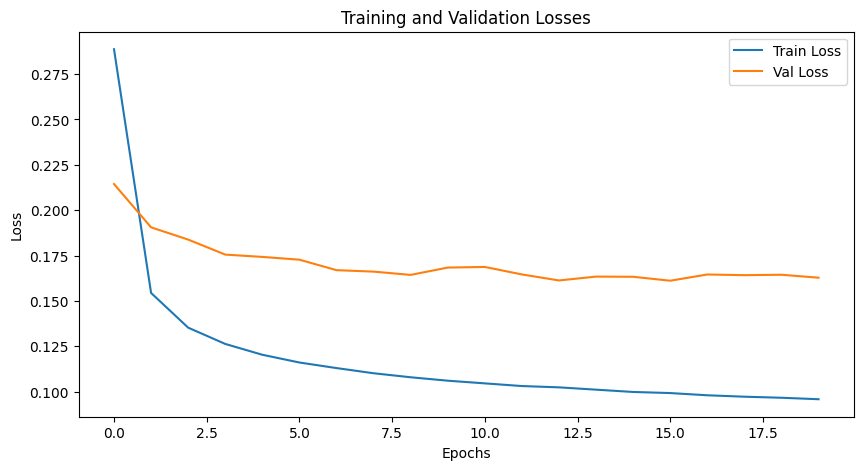

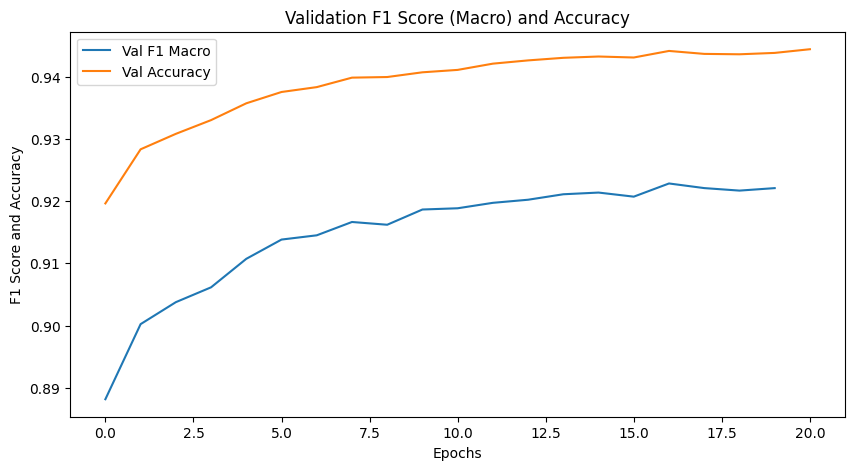

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(val_f1_macros, label='Val F1 Macro')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('F1 Score and Accuracy')
plt.legend()
plt.title('Validation F1 Score (Macro) and Accuracy')
plt.show()



In [19]:
def get_prediction(series, model, sequence_length):
    
    X = series.drop(columns=id_cols)
    X = X.drop(columns=['labels'], axis=0)
    
    num_features = X.shape[1]
    num_samples = len(X) // sequence_length
    
    X = np.array(X[:num_samples * sequence_length])
    X = X.reshape(num_samples, sequence_length, num_features)
    
    X = X.astype(np.float32)
    X_tensor = torch.tensor(X)
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)

    probs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).float()
    
    return probs.flatten().numpy(), preds.flatten().numpy()

def get_submission(series, probs, preds):
    
    events = pd.DataFrame(columns=['row_id', 'series_id', 'step', 'event', 'score'])
    
    if len(preds) < len(series):
        preds = np.pad(preds, (0, len(series) - len(preds)), 'constant', constant_values=0)
        probs = np.pad(probs, (0, len(series) - len(probs)), 'constant', constant_values=0)
                       
    if len(preds) > len(series):
        preds = preds[:len(series)]
        probs = probs[:len(series)]

    series["prediction"] = preds
    series["probability"] = probs
    
    series_ids = series['series_id'].unique().tolist()

    for idx in tqdm(series_ids):
        X = series[series['series_id'] == idx]
        
        pred_onsets = X[X['prediction'].diff() > 0]['step'].tolist()
        pred_wakeups = X[X['prediction'].diff() < 0]['step'].tolist()
        
        if len(pred_onsets) > 0:
            if min(pred_wakeups) < min(pred_onsets):
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups):
                pred_onsets = pred_onsets[:-1]

            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods:
                # Calculate score as mean probability over the period
                score = X[(X['step'] >= onset) & (X['step'] <= wakeup)]['probability'].mean()
                
                events.loc[len(events.index)] = [len(events.index), idx, onset,'onset', score]
                events.loc[len(events.index)] = [len(events.index), idx, wakeup, 'wakeup', score]

    events['row_id'] = events.index
    return events

In [21]:
# X_val_full.drop(columns=["prediction",  "probability"], inplace=True)
probs, preds = get_prediction(X_val_full, model, sequence_length)

In [22]:
submission = get_submission(X_val_full, probs, preds)
print(submission)

100%|██████████| 81/81 [00:11<00:00,  6.97it/s]

      row_id     series_id    step   event     score
0          0  062dbd4c95e6    7980   onset  0.735211
1          1  062dbd4c95e6    8940  wakeup  0.735211
2          2  062dbd4c95e6    9420   onset  0.881679
3          3  062dbd4c95e6   14460  wakeup  0.881679
4          4  062dbd4c95e6   60780   onset  0.928037
...      ...           ...     ...     ...       ...
4497    4497  fcca183903b7  584100  wakeup  0.930062
4498    4498  fcca183903b7  595500   onset  0.949073
4499    4499  fcca183903b7  602220  wakeup  0.949073
4500    4500  fcca183903b7  617220   onset  0.807223
4501    4501  fcca183903b7  620100  wakeup  0.807223

[4502 rows x 5 columns]


In [23]:
val_solution = train_events.filter(pl.col('series_id').is_in(val_ids)).select(['series_id', 'event', 'step']).to_pandas()


print(f"LSTM score: {score(val_solution, submission, tolerances, **column_names)}")
# submission.to_csv("sub.csv")
# val_solution.to_csv("sol.csv")

LSTM score: 0.24320740612991476
